## Problem Statemenmt

#### We have a sample IOT data. The task is to model the output variable. Output variable currently goes from 1 to 8. We could be classification problem. Here, the challenge is to experiment on multiple strategies to impute missing values and evalute the impact on accuracy of the model.

In [15]:
# Import Libraries

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer, IterativeImputer
#from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, make_scorer
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import IterativeImputer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

In [16]:
df = pd.read_csv("IOT_data.csv")

In [17]:
df.head()

,Sensor 1,Sensor 2,Sensor 3,Sensor 4,Sensor 5,Sensor 6,Sensor 7,Sensor 8,Time,Output,SubjectID
0,NaN,NaN,NaN,NaN,NaN,64.0,NaN,NaN,3/13/2021 5:54,2,8812EC1F-22DF-4729-A699-C7E639847E11
1,NaN,NaN,NaN,NaN,NaN,95.0,NaN,NaN,3/16/2021 13:44,2,8812EC1F-22DF-4729-A699-C7E639847E11
2,NaN,NaN,NaN,NaN,NaN,73.0,NaN,NaN,3/14/2021 11:29,2,8812EC1F-22DF-4729-A699-C7E639847E11
3,NaN,NaN,NaN,NaN,NaN,65.0,NaN,NaN,3/14/2021 7:50,2,8812EC1F-22DF-4729-A699-C7E639847E11
4,NaN,NaN,NaN,NaN,NaN,73.0,NaN,NaN,3/13/2021 1:31,2,8812EC1F-22DF-4729-A699-C7E639847E11


### Data Description

##### “SubjectID” column is the unique identifier for each subject. Sensors 1 to 8 represent 8 values from 8 different sensors. Here is some statistics on missing value:

In [18]:
df.isna().mean().round(4)*100

Sensor 1      99.97
Sensor 2      99.53
Sensor 3      99.10
Sensor 4     100.00
Sensor 5      99.99
Sensor 6       1.44
Sensor 7      99.97
Sensor 8      99.10
Time           0.00
Output         0.00
SubjectID      0.00
dtype: float64

We can see that most of the Sensors values are missing, sensor 4 has no values. It's best to remove sensor 4. For other sensors, we can try diffrent strategies to impute the missing value.

Lets drop Sensor 4 from df because all of its values are missing.

In [19]:
df.drop(['Sensor 4'],axis=1, inplace=True)

### Subjects

##### No missing values in subject column and we have only 5 unique values in the sample dataset.

In [20]:
pd.value_counts(df.SubjectID)

8812EC1F-22DF-4729-A699-C7E639847E11    24729
F32EF727-351C-480D-B723-43746211B179     8599
EC3FAE9D-8006-4534-AF4A-04FFDB0FA603     7913
399CCB09-7714-45EB-940C-180C2EA811C4     7823
FBDDEDA8-F680-498F-9B77-418A91BE2B73     5035
Name: SubjectID, dtype: int64

###  Strategy (Missing Value)

0. Drop missing values. Not acceptable here since it drops 100% of our data.
1. Replacing them with a distinctive number '-1' in our case.
2. Adding global mean, median with missing value indicator
3. Adding local mean, median as compared to each candidate respectively
4. Finding out missing value based on time series 
5. Finding out missing value based on another model 


### Selection criteria

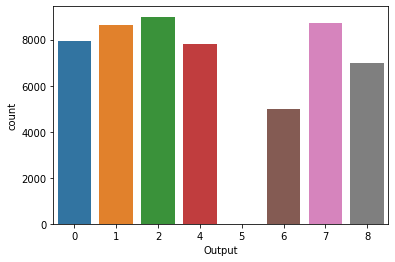

In [21]:
sns.countplot(x='Output', data=df)

Here, we can see that class with label '5' has very low values. We can ignore this class.

In [22]:
full_df = df[df['Output']!=5]

#### Model Experiments

We need to choose a simple model for our experiments. We can go with 'Random Forest' to be able to see what strategy works best for us

For metrics, we can verify accuracy with cross validation strategy.


In [23]:
clf = RandomForestClassifier(max_depth=5, max_features=None, n_estimators=10)

In [24]:
X_columns = [c for c in df.columns if 'Sensor' in c]
y_column = 'Output'

In [25]:

X_train = full_df[X_columns]
y_train = full_df[y_column]

In [26]:
df = df.set_index('Time')

### Strategy 1 ( Base line )

#### Implement a basic strategy of using constant value to fill the missing variable (-1).

In [27]:
imputer = SimpleImputer(missing_values=np.nan, add_indicator=True,
                            strategy='constant', fill_value=-1.)
pipeline = Pipeline(steps=[('i', imputer),('m',clf)])

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)

new_df = df



strategy1_score = cross_val_score(pipeline, X_train,y_train, scoring='accuracy')

In [28]:
strategy1_score.mean()

0.3773916258434237

### Strategy 2 ( Using global mean )

Implement global median to fill the missing value

In [29]:
imputer = SimpleImputer(missing_values=np.nan, add_indicator=True,
                            strategy='median')
pipeline = Pipeline(steps=[('i', imputer),('m',clf)])

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=1)
# evaluate model
scores = cross_val_score(pipeline, X_train, y_train, scoring='f1_weighted', cv=cv, n_jobs=-1, error_score='raise')


In [30]:
scores.mean()

0.3530096743105716

### Strategy 3 ( Using local median )
#### Implement local median to fill the missing value

In [31]:
full_df = df[df['Output']!=5]
full_df = full_df.groupby(['SubjectID']).transform(lambda x: x.fillna(x.median())).reset_index(drop=True)

X = full_df[X_columns]
y = full_df['Output']

imputer = SimpleImputer(missing_values=np.nan, add_indicator=True,
                            strategy='constant',fill_value=-1)
pipeline = Pipeline(steps=[('i', imputer),('m',clf)])


scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


In [32]:
scores

array([0.7654127 , 0.76596728, 0.76532027, 0.76153064, 0.76430354])

## Strategy 4 ( Using time series pattern ) 

we can Implement two strategies, one using global back fill / front fill. Idea is to use to future value of that sensor and propogate it backwards until null value is found or use a non-na value and propogate it forward until a non-null value is found. We are calling our first strategy as "global backfill" since it discards the information about the subject. 

In [33]:
filled_df = new_df.bfill().ffill()

In [34]:
X_train = filled_df[X_columns]
y_train = filled_df[y_column]


In [35]:
scores = cross_val_score(pipeline, X_train, y_train, scoring='f1_weighted', cv=cv, n_jobs=-1, error_score='raise')
scores.mean()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


0.4125191616347852

### Strategy 5 ( impute missing values based on a model )

we can try two popular approaches. One is using Iterative model to impute the missing value and another one is using KNN. It's one of the advanced techniques available for conventional models to fill out the missing gaps. Here is some intution behind them.

**Iterative Imputation** creates model for each variable type based on ther values. It uses linear model to do the prediction. supposed to be less accurate than KNN

**KNN imputation** works similarly as iterative mdoel but uses more complex model. KNN.

In [36]:
# implementation pending

### Variable importance graph

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
full_df = df[df['Output']!=5]
full_df = full_df.groupby(['SubjectID']).transform(lambda x: x.fillna(x.median())).reset_index(drop=True)

X = full_df[X_columns]
y = full_df['Output']

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:995: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


In [39]:
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')


In [40]:
scores

array([0.76532027, 0.76587485, 0.76532027, 0.76162307, 0.76421111])

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [42]:
clf = RandomForestClassifier(max_depth=5, max_features=None, n_estimators=100)

imputer = SimpleImputer(missing_values=np.nan, add_indicator=True,
                            strategy='constant',fill_value=-1)
pipeline = Pipeline(steps=[('i', imputer),('m',clf)])

In [43]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('i',
                 SimpleImputer(add_indicator=True, fill_value=-1,
                               strategy='constant')),
                ('m', RandomForestClassifier(max_depth=5, max_features=None))])

In [44]:
y_pred = pipeline.predict(X_test)

In [45]:
from sklearn.metrics import accuracy_score, classification_report

In [46]:
accuracy_score(y_test, y_pred)

0.7620526471458149

In [47]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1998
           1       1.00      1.00      1.00      2192
           2       0.59      0.39      0.47      2243
           4       1.00      1.00      1.00      1945
           6       1.00      1.00      1.00      1261
           7       0.44      0.96      0.60      2138
           8       0.00      0.00      0.00      1747

    accuracy                           0.76     13524
   macro avg       0.72      0.76      0.72     13524
weighted avg       0.71      0.76      0.72     13524



/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

In [48]:
import eli5
from eli5.sklearn import PermutationImportance

In [49]:
perm = PermutationImportance(pipeline, cv = 5, refit = True, n_iter = 50)


In [50]:
perm.fit(X_train.reset_index(drop=True),y_train.values)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classifier=True as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


PermutationImportance(cv=5,
                      estimator=Pipeline(steps=[('i',
                                                 SimpleImputer(add_indicator=True,
                                                               fill_value=-1,
                                                               strategy='constant')),
                                                ('m',
                                                 RandomForestClassifier(max_depth=5,
                                                                        max_features=None))]),
                      n_iter=50)

In [51]:
eli5.show_weights(perm, feature_names=X_columns)


Weight,Feature
0.2818 ± 0.0067,Sensor 7
0.2412 ± 0.0074,Sensor 5
0.1536 ± 0.1275,Sensor 3
0.0597 ± 0.0070,Sensor 6
0.0559 ± 0.0039,Sensor 1
0.0294 ± 0.1166,Sensor 2
0.0004 ± 0.0006,Sensor 8


Sensor 7 and Sensor 5 are the most important

# Conclusion

In [52]:
scores = {
    'Strategy 1': 37.6,
    'Strategy 2': 35.3,
    'Strategy 3': 76,
    'Strategy 4.1': 40,
    'Strategy 4.2' : 66
}

[Text(0, 0.5, 'accuracy'),
 Text(0.5, 0, 'Strategies'),
 Text(0.5, 1.0, 'Comparision of Strategies')]

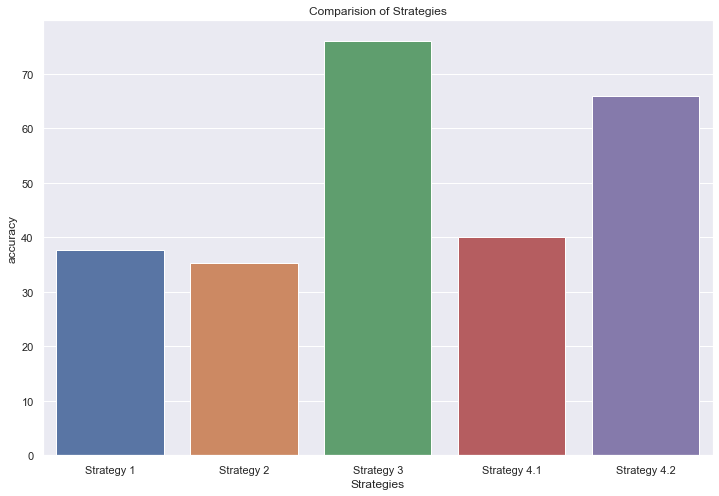

In [53]:
sns.set(rc={'figure.figsize': (12,8)})
ax = sns.barplot(x=list(scores.keys()), y=list(scores.values()))
ax.set(xlabel='Strategies', ylabel='accuracy', title='Comparision of Strategies')

Best accuracy on the test datset we got is around 75% using the streategy # 3 of local median imputation. It fills the missing value based on the median for each candidate group. It reflected a jump of 40% over the baseline. 

###  *Sensor 7* and *Sensor 5* are the most important

# Future improvements and implementation

Chosen strategy however is difficult to implement realttime. Using spark streaming and Kafka, we can keep track of last known value of the sensor and use that value in case of any missing element. We can also keep track of certain statistics based on the time of the day or hour of the day if that is important for that sensor.